# Simulasi Penataan Kontainer Kapal

Notebook ini mensimulasikan penataan kontainer berdasarkan kategori berat (berat/sedang/ringan) dan tujuan pelabuhan (Makassar, Ambon, Jayapura), dengan aturan:

- Kontainer berat ditempatkan di bawah, sedang di tengah, ringan di atas.
- Aksesibilitas bongkar: kontainer untuk pelabuhan awal harus lebih mudah diakses (lebih atas) dibanding pelabuhan akhir.
- Kapasitas contoh: 450 kontainer, dibagi ke 9 bay, masing-masing 50 slot (10 stack × 5 tier).

Visualisasi menggunakan color coding:
- Hijau: ringan
- Kuning: sedang
- Merah: berat

Silakan jalankan sel-sel di bawah berurutan.


In [ ]:
import numpy as np
import random
from typing import List, Dict, Tuple
from dataclasses import dataclass
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
import math
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed untuk konsistensi
random.seed(42)
np.random.seed(42)

@dataclass
class Container:
    id: int
    dest: str
    weight_cat: str
    weight_ton: float

# Constants
WEIGHT_CATEGORIES = ["light", "medium", "heavy"]
WEIGHT_PRIORITY = {"light": 1, "medium": 2, "heavy": 3}
WEIGHT_RANGES = {
    "light": (8.0, 12.9),
    "medium": (13.0, 19.9),
    "heavy": (20.0, 25.0),
}

# Mapping destinasi ke singkatan
DEST_TO_ABBR = {
    "Makassar": "MKS",
    "Ambon": "AMB",
    "Jayapura": "JYP"
}

# Mapping kategori berat ke singkatan
WEIGHT_ABBR = {
    "light": "L",
    "medium": "M",
    "heavy": "H"
}

# Mapping kategori berat ke warna
WEIGHT_TO_COLOR = {
    "light": "lightgreen",
    "medium": "gold",
    "heavy": "tomato"
}

# Parameter hidrostatik (DUMMY) — disesuaikan untuk kapal dummy container feeder 9x8x6
# CATATAN: ini tetap dummy/estimasi. Ganti dengan data hidrostatis asli (hydrostatic table / offsets) bila tersedia.
# Satuan: ton, meter.
# Kapasitas: 9 Bay x 8 Stack x 6 Tier = 432 slot kontainer
LIGHTSHIP_DISP_T = 2800.0 # berat lightship (estimasi untuk feeder ~100m, kapasitas 432 slot)
LIGHTSHIP_KG_M = 6.5 # estimasi CoG vertikal lightship (lebih rendah untuk kapal lebih kecil)
LIGHTSHIP_LCG_M = 0.0 # LCG relatif titik nol (midship), dummy
LIGHTSHIP_TCG_M = 0.0 # TCG relatif centerline (asumsi simetris)
KB_M = 3.5 # estimasi jarak keel -> pusat daya apung (disesuaikan untuk kapal lebih kecil)
# Aproksimasi BM dari waterplane kotak (lihat catatan di bawah)
BM_TRANSVERSE_M = 6.5 # BMt default (fallback jika tidak pakai aproksimasi)
BM_LONGITUDINAL_M = 180.0 # BMl ≈ 180 m (disesuaikan untuk kapal lebih kecil)

# tambahan/ubah di bagian konstanta (opsional)
USE_APPROX_BMl = True  # kalau True, hitung BMl aproksimasi; kalau False pakai BM_LONGITUDINAL_M

# Parameter geometri untuk aproksimasi BMt = I/∇ (opsional)
HYDRO_USE_APPROX_BMt = True
SHIP_LENGTH_M = 100.0 # perkiraan panjang waterline (m) - disesuaikan untuk 9 bay x 12.19m
SHIP_BEAM_M = 20.0 # perkiraan lebar waterline (m) - disesuaikan untuk 8 stack x 2.6m
WATERPLANE_COEFF = 0.75 # koefisien waterplane (I ≈ C_wp * L*B^3/12) - sedikit lebih baik
WATER_DENSITY_T_PER_M3 = 1.025 # densitas air laut (t/m^3)

# Geometri plan view (longitudinal & transverse) - DISESUAIKAN UNTUK KONTAINER 40 FOOT
# Dimensi disesuaikan untuk kapasitas 9 Bay x 8 Stack x 6 Tier
BAY_PITCH_M = 12.19 # jarak antar bay 40' dalam meter (9 bay x 12.19m ≈ 110m total)
ROW_SPACING_M = 2.6 # jarak antar stack (row) dalam meter (8 stack x 2.6m ≈ 21m total)
# Geometri vertikal tier untuk menghitung KG muatan (container feeder)
TIER_HEIGHT_M = 2.6 # jarak antar tier (umum untuk 20'/40' stack)
TIER_BASE_Z_M = 2.5 # elevasi tier 0 dari keel (disesuaikan untuk kapal lebih kecil)

# Tambahan parameter kontainer 40 foot untuk validasi
CONTAINER_LENGTH_M = 12.19  # panjang kontainer 40 foot
CONTAINER_WIDTH_M = 2.44    # lebar kontainer 40 foot
CONTAINER_HEIGHT_M = 2.59   # tinggi kontainer 40 foot

# Parameter kapasitas kargo yang disesuaikan
MAX_CARGO_WEIGHT_T = 8000.0  # maksimum berat kargo (ton) untuk kapasitas 432 slot
AVERAGE_CONTAINER_WEIGHT_T = 20.0  # rata-rata berat kontainer (ton)

In [25]:
class AdvancedBayAllocation:
    """Advanced bay allocation system with ML optimization"""
    
    def __init__(self, bays: int, stacks_per_bay: int, tiers_per_stack: int):
        self.bays = bays
        self.stacks_per_bay = stacks_per_bay
        self.tiers_per_stack = tiers_per_stack
        self.capacity_per_bay = stacks_per_bay * tiers_per_stack
        self.bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
        
        # ML Model for position scoring
        self.position_scorer = None
        self.scaler = StandardScaler()
        self.training_data = []
        
    def get_port_priority_order(self, ports_order: List[str]) -> Dict[str, int]:
        """
        Menentukan prioritas port berdasarkan urutan LIFO discharge
        Port terakhir (pertama discharged) = prioritas tertinggi = outer bays
        """
        priority = {}
        n = len(ports_order)
        for i, port in enumerate(ports_order):
            # Port terakhir dalam list = prioritas 1 (outer)
            # Port pertama dalam list = prioritas n (inner)
            priority[port] = n - i
        return priority
    
    def generate_mixed_bay_allocation(self, ports_order: List[str], 
                                    allocation_per_port: Dict[str, int]) -> Dict[str, List[int]]:
        """
        Generate bay allocation dengan kemungkinan mixed bays untuk balance
        """
        port_priority = self.get_port_priority_order(ports_order)
        
        # Hitung kebutuhan bay per port
        bay_needs = {}
        for port in ports_order:
            containers = allocation_per_port.get(port, 0)
            bay_needs[port] = max(1, int(np.ceil(containers / self.capacity_per_bay)))
        
        # Initial allocation - pure assignment
        initial_allocation = self._pure_bay_allocation(ports_order, bay_needs, port_priority)
        
        # Check if mixed allocation needed for balance
        mixed_allocation = self._optimize_with_mixed_bays(initial_allocation, ports_order, 
                                                        allocation_per_port, port_priority)
        
        return mixed_allocation
    
    def _pure_bay_allocation(self, ports_order: List[str], bay_needs: Dict[str, int], 
                            port_priority: Dict[str, int]) -> Dict[str, List[int]]:
        """Pure bay allocation tanpa mixing"""
        allocation = {port: [] for port in ports_order}
        
        # Sort ports by priority (highest priority = outer bays first)
        sorted_ports = sorted(ports_order, key=lambda p: port_priority[p], reverse=True)
        
        # Allocate bays from outside to inside
        bay_sequence = self._generate_outside_in_sequence()
        current_bay_idx = 0
        
        for port in sorted_ports:
            needed_bays = bay_needs[port]
            assigned_bays = []
            
            for _ in range(needed_bays):
                if current_bay_idx < len(bay_sequence):
                    assigned_bays.append(bay_sequence[current_bay_idx])
                    current_bay_idx += 1
            
            allocation[port] = sorted(assigned_bays)
        
        return allocation
    
    def _generate_outside_in_sequence(self) -> List[int]:
        """Generate bay sequence from outside to inside"""
        sequence = []
        left = 0
        right = self.bays - 1
        
        while left <= right:
            if left == right:
                sequence.append(left)
            else:
                sequence.extend([left, right])
            left += 1
            right -= 1
        
        return sequence
    
    def _optimize_with_mixed_bays(self, initial_allocation: Dict[str, List[int]], 
                                 ports_order: List[str], allocation_per_port: Dict[str, int],
                                 port_priority: Dict[str, int]) -> Dict[str, List[int]]:
        """
        Optimize allocation with mixed bays for better balance
        """
        # Calculate FA balance for initial allocation
        initial_balance = self._calculate_fa_balance(initial_allocation, allocation_per_port)
        
        # If balance is acceptable, return initial
        if initial_balance < 0.05:  # 5% threshold
            return initial_allocation
        
        # Try mixed allocation
        mixed_allocation = self._create_mixed_allocation(ports_order, allocation_per_port, 
                                                       port_priority, initial_allocation)
        
        mixed_balance = self._calculate_fa_balance(mixed_allocation, allocation_per_port)
        
        # Return better allocation
        if mixed_balance < initial_balance:
            print(f"Mixed allocation chosen - FA balance improved: {initial_balance:.3f} → {mixed_balance:.3f}")
            return mixed_allocation
        else:
            return initial_allocation
    
    def _create_mixed_allocation(self, ports_order: List[str], allocation_per_port: Dict[str, int],
                               port_priority: Dict[str, int], 
                               initial_allocation: Dict[str, List[int]]) -> Dict[str, List[int]]:
        """Create mixed bay allocation untuk balance"""
        
        # Identify adjacent ports that can share bays
        mixed_allocation = {port: [] for port in ports_order}
        used_bays = set()
        
        # Sort ports by priority for allocation
        sorted_ports = sorted(ports_order, key=lambda p: port_priority[p], reverse=True)
        
        for i, port in enumerate(sorted_ports):
            containers = allocation_per_port.get(port, 0)
            needed_capacity = containers
            allocated_capacity = 0
            
            # First, try to get dedicated bays
            bay_sequence = self._generate_outside_in_sequence()
            
            for bay in bay_sequence:
                if bay in used_bays:
                    continue
                    
                if allocated_capacity < needed_capacity:
                    mixed_allocation[port].append(bay)
                    used_bays.add(bay)
                    allocated_capacity += self.capacity_per_bay
                    
                    # Check if we can share this bay with adjacent priority port
                    if allocated_capacity > needed_capacity and i + 1 < len(sorted_ports):
                        next_port = sorted_ports[i + 1]
                        remaining_capacity = allocated_capacity - needed_capacity
                        next_port_need = allocation_per_port.get(next_port, 0)
                        
                        if remaining_capacity >= min(next_port_need, self.capacity_per_bay // 2):
                            # Share this bay
                            if bay not in mixed_allocation[next_port]:
                                mixed_allocation[next_port].append(bay)
                                print(f"Bay {bay} shared between {port} and {next_port}")
                
                if allocated_capacity >= needed_capacity:
                    break
        
        # Ensure all bays are allocated
        all_assigned_bays = set()
        for bays_list in mixed_allocation.values():
            all_assigned_bays.update(bays_list)
        
        unassigned_bays = [b for b in range(self.bays) if b not in all_assigned_bays]
        if unassigned_bays:
            # Assign to last port
            mixed_allocation[sorted_ports[-1]].extend(unassigned_bays)
        
        # Sort bay lists
        for port in mixed_allocation:
            mixed_allocation[port] = sorted(mixed_allocation[port])
        
        return mixed_allocation
    
    def _calculate_fa_balance(self, allocation: Dict[str, List[int]], 
                            allocation_per_port: Dict[str, int]) -> float:
        """Calculate front-aft balance ratio"""
        front_weight = 0.0
        aft_weight = 0.0
        center_weight = 0.0
        
        for port, bays in allocation.items():
            port_weight = allocation_per_port.get(port, 0) * 15.0  # Average weight assumption
            weight_per_bay = port_weight / len(bays) if bays else 0
            
            for bay in bays:
                coord = self.bay_coords[bay]
                if coord < 0:
                    front_weight += weight_per_bay
                elif coord > 0:
                    aft_weight += weight_per_bay
                else:
                    center_weight += weight_per_bay
        
        # Distribute center weight equally
        front_weight += center_weight / 2
        aft_weight += center_weight / 2
        
        total_weight = front_weight + aft_weight
        if total_weight == 0:
            return 0.0
        
        return abs(front_weight - aft_weight) / total_weight

In [26]:
class MLStowagePlanner:
    """Machine Learning enhanced stowage planner"""
    
    def __init__(self, bays: int, stacks_per_bay: int, tiers_per_stack: int):
        self.bays = bays
        self.stacks_per_bay = stacks_per_bay
        self.tiers_per_stack = tiers_per_stack
        self.bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
        
        # ML components
        self.position_model = RandomForestRegressor(n_estimators=50, random_state=42)
        self.scaler = StandardScaler()
        self.is_trained = False
        
        # Bay allocator
        self.bay_allocator = AdvancedBayAllocation(bays, stacks_per_bay, tiers_per_stack)
    
    def extract_features(self, bay: int, stack: int, tier: int, container: Container,
                        current_assignment: Dict, bay_weights: Dict) -> np.array:
        """Extract features for ML model"""
        features = [
            bay,  # Bay position
            stack,  # Stack position
            tier,  # Tier position
            self.bay_coords[bay],  # Bay coordinate (FA position)
            container.weight_ton,  # Container weight
            WEIGHT_PRIORITY[container.weight_cat],  # Weight category priority
            bay_weights.get(bay, {}).get('total', 0),  # Current bay weight
            bay_weights.get(bay, {}).get('stacks', [0]*self.stacks_per_bay)[stack],  # Current stack weight
            abs(self.bay_coords[bay]),  # Distance from center
            len([c for c in current_assignment.values() if c.dest == container.dest]),  # Same dest count
        ]
        return np.array(features).reshape(1, -1)
    
    def calculate_position_score(self, bay: int, stack: int, tier: int, container: Container,
                               current_assignment: Dict, bay_weights: Dict, 
                               fa_imbalance: float, fa_preference: str) -> float:
        """Calculate position score using heuristics + ML (if trained)"""
        
        # Base heuristic score
        bay_coord = self.bay_coords[bay]
        stack_weight = bay_weights.get(bay, {}).get('stacks', [0]*self.stacks_per_bay)[stack]
        
        # Base score from stack weight (prefer lighter stacks)
        score = stack_weight
        
        # FA balance scoring
        fa_boost = 8.0 if fa_imbalance > 150 else 6.0
        
        if fa_preference == "front" and bay_coord < 0:
            score -= container.weight_ton * fa_boost
        elif fa_preference == "aft" and bay_coord > 0:
            score -= container.weight_ton * fa_boost
        elif fa_preference == "balanced":
            score -= container.weight_ton * 2.0
        
        # Weight distribution bonus
        if container.weight_cat == "heavy":
            if (fa_preference == "front" and bay_coord < 0) or (fa_preference == "aft" and bay_coord > 0):
                score -= container.weight_ton * 3.0
        
        # ML enhancement (if model is trained)
        if self.is_trained:
            try:
                features = self.extract_features(bay, stack, tier, container, 
                                               current_assignment, bay_weights)
                features_scaled = self.scaler.transform(features)
                ml_score = self.position_model.predict(features_scaled)[0]
                # Combine heuristic and ML scores
                score = 0.7 * score + 0.3 * ml_score
            except:
                pass  # Fallback to heuristic only
        
        return score
    
    def train_position_model(self, training_scenarios: List[Dict]):
        """Train ML model from successful stowage scenarios"""
        if not training_scenarios:
            return
        
        X, y = [], []
        
        for scenario in training_scenarios:
            assignment = scenario['assignment']
            containers = scenario['containers']
            bay_weights = scenario['bay_weights']
            
            for (bay, stack, tier), container in assignment.items():
                features = self.extract_features(bay, stack, tier, container, 
                                               assignment, bay_weights)
                # Target score based on FA balance achievement
                fa_balance = scenario.get('fa_balance', 0.1)
                target_score = max(0, 1.0 - fa_balance * 10)  # Better balance = higher score
                
                X.append(features.flatten())
                y.append(target_score)
        
        if len(X) > 10:  # Minimum samples for training
            X = np.array(X)
            y = np.array(y)
            
            self.scaler.fit(X)
            X_scaled = self.scaler.transform(X)
            
            self.position_model.fit(X_scaled, y)
            self.is_trained = True
            print(f"ML model trained with {len(X)} samples")
    
    def plan_stowage_with_mixed_bays(self, containers: List[Container], ports_order: List[str]) -> Dict:
        """
        Enhanced stowage planning with mixed bay allocation
        """
        # Calculate allocation per port
        allocation_per_port = {port: len([c for c in containers if c.dest == port]) 
                             for port in ports_order}
        
        # Generate mixed bay allocation
        port_to_bays = self.bay_allocator.generate_mixed_bay_allocation(ports_order, allocation_per_port)
        
        print("Bay Allocation:")
        for port, bays in port_to_bays.items():
            print(f"  {port}: Bays {bays}")
        
        # Allocate rows within bays for mixed usage
        row_allocation = self._allocate_mixed_rows(ports_order, allocation_per_port, 
                                                  port_to_bays)
        
        # Plan stowage with ML enhancement
        assignment = self._plan_stowage_ml_enhanced(containers, ports_order, 
                                                   port_to_bays, row_allocation)
        
        return {
            'assignment': assignment,
            'port_to_bays': port_to_bays,
            'row_allocation': row_allocation
        }
    
    def _allocate_mixed_rows(self, ports_order: List[str], allocation_per_port: Dict[str, int],
                           port_to_bays: Dict[str, List[int]]) -> Dict[Tuple[int, str], List[int]]:
        """Allocate rows within bays for potentially mixed usage (robust version)"""
        row_allocation: Dict[Tuple[int, str], List[int]] = {}

        # Precompute for each bay which ports claim it (to handle sharing)
        bay_to_ports: Dict[int, List[str]] = {}
        for port in ports_order:
            for bay in port_to_bays.get(port, []):
                bay_to_ports.setdefault(bay, []).append(port)

        for port in ports_order:
            port_bays = port_to_bays.get(port, [])
            total_containers = allocation_per_port.get(port, 0)

            if not port_bays or total_containers == 0:
                # still ensure keys exist for consistency (empty lists)
                for bay in port_bays:
                    row_allocation.setdefault((bay, port), [])
                continue

            # distribute containers roughly evenly across the bay list
            containers_per_bay = total_containers // len(port_bays)
            remainder = total_containers % len(port_bays)

            for i, bay in enumerate(port_bays):
                bay_containers = containers_per_bay + (1 if i < remainder else 0)
                # rows_needed = number of stacks we will use in this bay for this port
                rows_needed = min(int(np.ceil(bay_containers / self.tiers_per_stack)),
                                  self.stacks_per_bay)
                if rows_needed <= 0:
                    row_allocation[(bay, port)] = []
                    continue

                sharing_ports = bay_to_ports.get(bay, [])

                if len(sharing_ports) == 1:
                    # dedicated bay for this port: center-out allocation
                    allocated_rows = self._center_out_allocation(rows_needed)
                else:
                    # shared bay: split stacks among sharing ports
                    # create a deterministic ordering of sharing_ports
                    sharing_ports_sorted = sorted(sharing_ports, key=lambda p: ports_order.index(p))
                    # index among sharers
                    idx = sharing_ports_sorted.index(port)
                    # compute equal split of stacks across sharing ports
                    base_share = self.stacks_per_bay // len(sharing_ports_sorted)
                    extra = self.stacks_per_bay % len(sharing_ports_sorted)
                    # the port gets base_share + (1 if idx < extra else 0) stacks
                    my_share = base_share + (1 if idx < extra else 0)
                    # pick edge blocks for earlier ports and center blocks for last ones:
                    # build ordered stack indices from 0..(S-1)
                    all_rows = list(range(self.stacks_per_bay))
                    # We'll allocate contiguous blocks for simplicity: compute start index
                    # For fairness, distribute blocks sequentially
                    start = sum(base_share + (1 if j < extra else 0) for j in range(idx))
                    allocated_rows = all_rows[start:start + my_share]
                    # If computed allocation is short/empty, fallback to center-out small set
                    if not allocated_rows:
                        allocated_rows = self._center_out_allocation(min(rows_needed, self.stacks_per_bay))

                    # shrink to requested rows_needed (if my_share > rows_needed)
                    allocated_rows = allocated_rows[:rows_needed]

                # Ensure we always provide something (fallback)
                if not allocated_rows:
                    allocated_rows = list(range(self.stacks_per_bay))

                row_allocation[(bay, port)] = sorted(allocated_rows)

        # Ensure every claimed (bay, port) has an entry
        for bay, ports in bay_to_ports.items():
            for p in ports:
                row_allocation.setdefault((bay, p), list(range(self.stacks_per_bay)))

        return row_allocation

    
    def _center_out_allocation(self, rows_needed: int) -> List[int]:
        """Allocate rows from center outward"""
        center = self.stacks_per_bay // 2
        allocated = [center]
        
        for i in range(1, rows_needed):
            if center - i >= 0 and len(allocated) < rows_needed:
                allocated.append(center - i)
            if center + i < self.stacks_per_bay and len(allocated) < rows_needed:
                allocated.append(center + i)
        
        return allocated[:rows_needed]
    
    def _plan_stowage_ml_enhanced(self, containers: List[Container], ports_order: List[str],
                                port_to_bays: Dict[str, List[int]], 
                                row_allocation: Dict[Tuple[int, str], List[int]]) -> Dict:
        """Enhanced stowage planning with ML scoring (robust bottom-up fill)."""

        # Group containers by destination
        by_port = {p: [] for p in ports_order}
        for c in containers:
            if c.dest in by_port:
                by_port[c.dest].append(c)

        # Sort by weight priority (heavy first for better stability)
        for port in by_port:
            by_port[port] = sorted(by_port[port], key=lambda c: WEIGHT_PRIORITY[c.weight_cat], reverse=True)

        assignment: Dict[Tuple[int,int,int], Container] = {}
        bay_weights = {bay: {'total': 0.0, 'stacks': [0.0]*self.stacks_per_bay} for bay in range(self.bays)}
        bay_stack_fill = {bay: [0]*self.stacks_per_bay for bay in range(self.bays)}  # count of tiers filled per stack

        # Helper functions (local to keep using bay_weights/assignment closures)
        def calculate_fa_imbalance():
            front_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] < 0)
            aft_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] > 0)
            center_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] == 0)
            front_weight += center_weight / 2
            aft_weight += center_weight / 2
            return abs(front_weight - aft_weight)

        def get_fa_preference():
            front_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] < 0)
            aft_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] > 0)
            center_weight = sum(bay_weights[b]['total'] for b in range(self.bays) if self.bay_coords[b] == 0)
            front_weight += center_weight / 2
            aft_weight += center_weight / 2
            if front_weight < aft_weight - 10:
                return "front"
            elif aft_weight < front_weight - 10:
                return "aft"
            return "balanced"

        def can_place_container_strict(bay: int, stack: int, tier: int, container: Container) -> bool:
            """
            Strict weight rules:
            - position must be empty
            - if tier > 0, lower tier must exist (we fill bottom-up so this should hold)
            - weight ordering: cannot place lighter below heavier (priority logic)
            """
            if (bay, stack, tier) in assignment:
                return False

            if tier > 0:
                lower_pos = (bay, stack, tier - 1)
                if lower_pos not in assignment:
                    return False
                lower_cont = assignment[lower_pos]
                if WEIGHT_PRIORITY[container.weight_cat] < WEIGHT_PRIORITY[lower_cont.weight_cat]:
                    return False

            # If there is an upper container already, ensure weight ordering still valid
            if tier < self.tiers_per_stack - 1:
                upper_pos = (bay, stack, tier + 1)
                if upper_pos in assignment:
                    upper_cont = assignment[upper_pos]
                    if WEIGHT_PRIORITY[container.weight_cat] > WEIGHT_PRIORITY[upper_cont.weight_cat]:
                        return False

            return True

        # LIFO: place ports in reverse discharge order (last port first)
        for port in reversed(ports_order):
            port_containers = by_port.get(port, [])
            candidate_bays = list(port_to_bays.get(port, []))

            for container in port_containers:
                best_score = float('inf')
                best_pos = None

                current_fa_imbalance = calculate_fa_imbalance()
                fa_pref = get_fa_preference()

                # Search candidate bays/rows and evaluate best first-free-tier per stack
                for bay in candidate_bays:
                    allocated_rows = row_allocation.get((bay, port), list(range(self.stacks_per_bay)))
                    for stack in allocated_rows:
                        # Find first free tier in this stack (bottom-up)
                        first_free_tier = None
                        for tier in range(self.tiers_per_stack):
                            if (bay, stack, tier) not in assignment:
                                first_free_tier = tier
                                break
                        if first_free_tier is None:
                            # stack full
                            continue

                        # Evaluate strict placement feasibility for that candidate tier
                        if not can_place_container_strict(bay, stack, first_free_tier, container):
                            # If strict rules fail, skip — we want valid bottom-up placements only
                            continue

                        # Compute score (lower is better in your calculate_position_score)
                        score = self.calculate_position_score(bay, stack, first_free_tier,
                                                            container, assignment, bay_weights,
                                                            current_fa_imbalance, fa_pref)
                        if score < best_score:
                            best_score = score
                            best_pos = (bay, stack, first_free_tier)

                # If we found a best_pos, place it and update weights/fill counters
                if best_pos is not None:
                    bay, stack, tier = best_pos
                    assignment[(bay, stack, tier)] = container
                    bay_weights[bay]['total'] += container.weight_ton
                    bay_weights[bay]['stacks'][stack] += container.weight_ton
                    bay_stack_fill[bay][stack] += 1
                else:
                    # Option: a permissive fallback pass (try ignoring strict lower-tier requirement)
                    # here we try one more pass, allowing placement if below tier is missing (not ideal but recovers)
                    fallback_placed = False
                    for bay in candidate_bays:
                        allocated_rows = row_allocation.get((bay, port), list(range(self.stacks_per_bay)))
                        for stack in allocated_rows:
                            for tier in range(self.tiers_per_stack):
                                if (bay, stack, tier) in assignment:
                                    continue
                                # permissive check: only weight-ordering constraints enforced when neighbors exist
                                # check weight vs upper (if any)
                                if tier < self.tiers_per_stack - 1:
                                    up = (bay, stack, tier + 1)
                                    if up in assignment and WEIGHT_PRIORITY[container.weight_cat] > WEIGHT_PRIORITY[assignment[up].weight_cat]:
                                        continue
                                # accept this position
                                assignment[(bay, stack, tier)] = container
                                bay_weights[bay]['total'] += container.weight_ton
                                bay_weights[bay]['stacks'][stack] += container.weight_ton
                                bay_stack_fill[bay][stack] += 1
                                fallback_placed = True
                                break
                            if fallback_placed:
                                break
                        if fallback_placed:
                            break

                    if not fallback_placed:
                        # final fail - print concise debug
                        print(f"Warning: Could not place container {container.id} for {port} - candidates {candidate_bays}")
        return assignment

In [27]:
# Utility functions
def normalize_mix(mix: Dict[str, float]) -> Dict[str, float]:
    total = sum(mix.values())
    if total == 0:
        n = len(mix)
        return {k: 1.0 / n for k in mix}
    return {k: v / total for k, v in mix.items()}

def generate_containers(total: int, allocation_per_port: Dict[str, int],
                       weight_mix: Dict[str, Dict[str, float]]) -> List[Container]:
    containers = []
    container_id = 1
    
    for port, count in allocation_per_port.items():
        mix = normalize_mix(weight_mix.get(port, {"light": 1/3, "medium": 1/3, "heavy": 1/3}))
        probs = [mix.get("light", 0), mix.get("medium", 0), mix.get("heavy", 0)]
        cat_counts = np.random.multinomial(count, probs)
        cats = ["light", "medium", "heavy"]
        
        for cat, c in zip(cats, cat_counts):
            for _ in range(c):
                wmin, wmax = WEIGHT_RANGES[cat]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=port, 
                                          weight_cat=cat, weight_ton=w))
                container_id += 1
    
    # Adjust if needed
    if len(containers) != total:
        if len(containers) > total:
            containers = containers[:total]
        else:
            while len(containers) < total:
                wmin, wmax = WEIGHT_RANGES["light"]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=list(allocation_per_port.keys())[-1], 
                                          weight_cat="light", weight_ton=w))
                container_id += 1
    
    return containers

In [28]:
def analyze_stowage_result(assignment: Dict, bays: int, stacks_per_bay: int, 
                          tiers_per_stack: int, ports_order: List[str]) -> Dict:
    """Analyze stowage result and calculate metrics"""
    if not assignment:
        return {"error": "No assignment to analyze"}
    
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    
    # Calculate weights per bay
    bay_weights = {bay: 0.0 for bay in range(bays)}
    port_weights = {port: 0.0 for port in ports_order}
    total_weight = 0.0
    
    for (bay, stack, tier), container in assignment.items():
        weight = container.weight_ton
        bay_weights[bay] += weight
        port_weights[container.dest] += weight
        total_weight += weight
    
    # Calculate FA balance
    front_weight = sum(bay_weights[b] for b in range(bays) if bay_coords[b] < 0)
    aft_weight = sum(bay_weights[b] for b in range(bays) if bay_coords[b] > 0)
    center_weight = sum(bay_weights[b] for b in range(bays) if bay_coords[b] == 0)
    
    front_weight += center_weight / 2
    aft_weight += center_weight / 2
    
    fa_balance_ratio = abs(front_weight - aft_weight) / total_weight if total_weight > 0 else 0
    fa_imbalance_tons = abs(front_weight - aft_weight)
    
    # Container count per bay and port
    bay_container_count = {bay: 0 for bay in range(bays)}
    port_container_count = {port: 0 for port in ports_order}
    
    for (bay, stack, tier), container in assignment.items():
        bay_container_count[bay] += 1
        port_container_count[container.dest] += 1
    
    return {
        "total_containers": len(assignment),
        "total_weight": total_weight,
        "fa_balance_ratio": fa_balance_ratio,
        "fa_imbalance_tons": fa_imbalance_tons,
        "front_weight": front_weight,
        "aft_weight": aft_weight,
        "bay_weights": bay_weights,
        "port_weights": port_weights,
        "bay_container_count": bay_container_count,
        "port_container_count": port_container_count
    }

In [29]:
def compute_weight_tensors(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                          stacks_per_bay: int, tiers_per_stack: int):
    W = np.zeros((bays, stacks_per_bay, tiers_per_stack), dtype=float)
    for (bay, stack, tier), c in assignment.items():
        W[bay, stack, tier] = c.weight_ton
    return W

def evaluate_balance(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                    stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, float]:
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total = W.sum()

    # Koordinat
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_coords = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)

    X = bay_coords[:, None, None]
    Y = stack_coords[None, :, None]

    # Left-Right balance
    left_mask = (Y < 0).astype(float) + 0.5*(Y == 0).astype(float)
    right_mask = (Y > 0).astype(float) + 0.5*(Y == 0).astype(float)
    left = float((W * left_mask).sum())
    right = float((W * right_mask).sum())
    lr_diff = abs(left - right)
    lr_ratio = lr_diff / total if total > 0 else 0.0

    # Front-Aft balance
    front_mask = (X < 0).astype(float) + 0.5*(X == 0).astype(float)
    aft_mask = (X > 0).astype(float) + 0.5*(X == 0).astype(float)
    front = float((W * front_mask).sum())
    aft = float((W * aft_mask).sum())
    fa_diff = abs(front - aft)
    fa_ratio = fa_diff / total if total > 0 else 0.0

    # Vertical balance
    bottom = W[:, :, :tiers_per_stack//2].sum()
    top = W[:, :, tiers_per_stack//2:].sum()
    vt_diff = abs(bottom - top)
    vt_ratio = vt_diff / total if total > 0 else 0.0

    return {
        "total_weight_t": float(total),
        "left_t": float(left), "right_t": float(right), "lr_diff_t": float(lr_diff), "lr_imbalance_ratio": float(lr_ratio),
        "front_t": float(front), "aft_t": float(aft), "fa_diff_t": float(fa_diff), "fa_imbalance_ratio": float(fa_ratio),
        "bottom_t": float(bottom), "top_t": float(top), "vt_diff_t": float(vt_diff), "vt_imbalance_ratio": float(vt_ratio),
    }

def print_balance_report(metrics: Dict[str, float]):
    print(f"Total berat: {metrics['total_weight_t']:.1f} t")
    print("Kiri–Kanan (LR):")
    print(f"  Left: {metrics['left_t']:.1f} t | Right: {metrics['right_t']:.1f} t | Selisih: {metrics['lr_diff_t']:.1f} t ({metrics['lr_imbalance_ratio']*100:.2f}%)")
    print("Depan–Belakang (FA):")
    print(f"  Front: {metrics['front_t']:.1f} t | Aft: {metrics['aft_t']:.1f} t | Selisih: {metrics['fa_diff_t']:.1f} t ({metrics['fa_imbalance_ratio']*100:.2f}%)")
    print("Atas–Bawah (Vertical):")
    print(f"  Bottom: {metrics['bottom_t']:.1f} t | Top: {metrics['top_t']:.1f} t | Selisih: {metrics['vt_diff_t']:.1f} t ({metrics['vt_imbalance_ratio']*100:.2f}%)")

In [ ]:
def visualize_all_bays_detailed(assignment: Dict[Tuple[int,int,int], Container], bays: int, 
                               stacks_per_bay: int, tiers_per_stack: int):
    """Visualisasi detail semua bay dengan side view per bay"""
    # Tentukan grid layout untuk subplot
    cols = 3  # 6 bay per baris
    rows = math.ceil(bays / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(24, rows * 3.8))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Calculate total weight per bay
    bay_weights = {}
    for bay in range(bays):
        bay_weights[bay] = 0.0
        for stack in range(stacks_per_bay):
            for tier in range(tiers_per_stack):
                pos = (bay, stack, tier)
                if pos in assignment:
                    bay_weights[bay] += assignment[pos].weight_ton
    
    for bay in range(bays):
        row_idx = bay // cols
        col_idx = bay % cols
        ax = axes[row_idx, col_idx]
        
        # Gambar bay sebagai side view (stack horizontal, tier vertikal)
        for stack in range(stacks_per_bay):
            for tier in range(tiers_per_stack):
                x = stack
                y = tier  
                
                pos = (bay, stack, tier)
                if pos in assignment:
                    container = assignment[pos]
                    color = WEIGHT_TO_COLOR[container.weight_cat]
                    
                    # Gambar kotak kontainer
                    rect = plt.Rectangle((x-0.45, y-0.45), 0.9, 0.9, 
                                       facecolor=color, edgecolor='black', linewidth=1)
                    ax.add_patch(rect)
                    
                    # Label dengan ID, tujuan, kategori berat, dan berat
                    container_id = f"#{container.id}"
                    dest_abbr = DEST_TO_ABBR[container.dest]
                    weight_abbr = WEIGHT_ABBR[container.weight_cat]
                    weight_val = f"{container.weight_ton:.1f}"
                    
                    # Teks multi-line dengan ID container
                    label = f"{container_id}\n{dest_abbr}-{weight_abbr}\n{weight_val}t"
                    ax.text(x, y, label, ha='center', va='center', 
                           fontsize=6, fontweight='bold', color='black')
                else:
                    # Slot kosong
                    rect = plt.Rectangle((x-0.45, y-0.45), 0.9, 0.9, 
                                       facecolor='lightgray', edgecolor='gray', 
                                       linewidth=0.5, alpha=0.3)
                    ax.add_patch(rect)
        
        # Setting axis untuk bay ini dengan total berat
        ax.set_xlim(-0.5, stacks_per_bay - 0.5)
        ax.set_ylim(-0.5, tiers_per_stack - 0.5)
        ax.set_title(f'Bay {bay+1}\n({bay_weights[bay]:.0f} ton)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Row')
        ax.set_ylabel('Tier')
        
        # Grid dan ticks
        ax.set_xticks(range(stacks_per_bay))
        ax.set_yticks(range(tiers_per_stack))
        ax.set_xticklabels([str(i+1) for i in range(stacks_per_bay)])  # Row mulai dari 1
        ax.set_yticklabels([str(i+1) for i in range(tiers_per_stack)])  # Tier mulai dari 1
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    # Sembunyikan subplot kosong jika ada
    for bay in range(bays, rows * cols):
        row_idx = bay // cols
        col_idx = bay % cols
        axes[row_idx, col_idx].axis('off')
    
    # Calculate balance metrics for the report
    metrics = evaluate_balance(assignment, bays, stacks_per_bay, tiers_per_stack)
    
    # Create legends
    # Weight category legend
    weight_legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=f'{cat.capitalize()}') 
                             for cat, color in WEIGHT_TO_COLOR.items()]
    
    # Destination legend
    dest_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
                                      markersize=8, label=f'{abbr} = {dest}') 
                           for dest, abbr in DEST_TO_ABBR.items()]
    
    # Create combined legend
    all_legend_elements = weight_legend_elements + dest_legend_elements
    
    # Add legends
    legend = fig.legend(handles=all_legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99), 
              fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # Add balance report text below the legend
    balance_text = f"""=== Balance Report ===
Total berat: {metrics['total_weight_t']:.1f} t
Kiri–Kanan (LR) Selisih: {metrics['lr_diff_t']:.1f} t ({metrics['lr_imbalance_ratio']*100:.2f}%) :
  Left: {metrics['left_t']:.1f} t | Right: {metrics['right_t']:.1f} t
Depan–Belakang (FA) Selisih: {metrics['fa_diff_t']:.1f} t ({metrics['fa_imbalance_ratio']*100:.2f}%) :
  Front: {metrics['front_t']:.1f} t | Aft: {metrics['aft_t']:.1f} t
Atas–Bawah (Vertical) Selisih: {metrics['vt_diff_t']:.1f} t ({metrics['vt_imbalance_ratio']*100:.2f}%):
  Bottom: {metrics['bottom_t']:.1f} t | Top: {metrics['top_t']:.1f} t"""
    
    # Position balance report below the legend
    # Get legend position and place balance report below it
    legend_bbox = legend.get_window_extent().transformed(fig.transFigure.inverted())
    balance_y = legend_bbox.y0 - 0.15  # Position below legend with some spacing
    
    # Add text box with balance report positioned below legend
    fig.text(0.99, balance_y, balance_text, fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    
    # Title dan layout
    fig.suptitle('Container Stowage Plan - All Bays (Side View)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, right=0.85, bottom=0.05)  # Reduced bottom margin since balance report is now positioned differently
    plt.show()

def visualize_single_bay(assignment: Dict[Tuple[int,int,int], Container], bay_num: int,
                        stacks_per_bay: int, tiers_per_stack: int):
    """Visualisasi detail satu bay tertentu"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate total weight for this bay
    bay_weight = 0.0
    for stack in range(stacks_per_bay):
        for tier in range(tiers_per_stack):
            pos = (bay_num, stack, tier)
            if pos in assignment:
                bay_weight += assignment[pos].weight_ton
    
    for stack in range(stacks_per_bay):
        for tier in range(tiers_per_stack):
            x = stack
            y = tier
            
            pos = (bay_num, stack, tier)
            if pos in assignment:
                container = assignment[pos]
                color = WEIGHT_TO_COLOR[container.weight_cat]
                
                # Gambar kotak kontainer
                rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                   facecolor=color, edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                
                # Label detail dengan ID container
                dest_abbr = DEST_TO_ABBR[container.dest]
                weight_abbr = WEIGHT_ABBR[container.weight_cat]
                weight_val = f"{container.weight_ton:.1f}"
                container_id = f"#{container.id}"
                
                # Teks multi-line dengan info lengkap
                label = f"{container_id}\n{dest_abbr}-{weight_abbr}\n{weight_val}t"
                ax.text(x, y, label, ha='center', va='center', 
                       fontsize=10, fontweight='bold', color='black')
            else:
                # Slot kosong
                rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                   facecolor='white', edgecolor='gray', 
                                   linewidth=1, alpha=0.5)
                ax.add_patch(rect)
                ax.text(x, y, 'Empty', ha='center', va='center', 
                       fontsize=8, color='gray', style='italic')
    
    ax.set_xlim(-0.5, stacks_per_bay - 0.5)
    ax.set_ylim(-0.5, tiers_per_stack - 0.5)
    ax.set_title(f'Bay {bay_num+1} - Detailed View ({bay_weight:.0f} ton)', 
             fontsize=14, fontweight='bold')
    ax.set_xlabel('Row', fontsize=12)
    ax.set_ylabel('Tier', fontsize=12)
    
    # Ticks dan labels
    ax.set_xticks(range(stacks_per_bay))
    ax.set_yticks(range(tiers_per_stack))
    ax.set_xticklabels([str(i+1) for i in range(stacks_per_bay)])  # Row mulai dari 1
    ax.set_yticklabels([str(i+1) for i in range(tiers_per_stack)])  # Tier mulai dari 1
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Create combined legend with weight categories and destinations
    # Weight category legend
    weight_legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=f'{cat.capitalize()}') 
                             for cat, color in WEIGHT_TO_COLOR.items()]
    
    # Destination legend
    dest_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
                                      markersize=8, label=f'{abbr} = {dest}') 
                           for dest, abbr in DEST_TO_ABBR.items()]
    
    # Combine legends
    all_legend_elements = weight_legend_elements + dest_legend_elements
    
    # Legend di pojok kanan luar plot area
    ax.legend(handles=all_legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
              fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # Atur layout: plot di kiri, legend di kanan
    plt.tight_layout()
    plt.subplots_adjust(right=0.7)  # Plot hanya ambil 70% lebar, sisanya untuk legend
    plt.show()

In [ ]:
def compute_cargo_cog(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                       stacks_per_bay: int, tiers_per_stack: int) -> Tuple[float,float,float,float]:
    """Hitung total berat kargo dan CoG 3D (LCG, TCG, KG) dalam meter.
    - Koordinat longitudinal memakai pitch bay 40' aktual (BAY_PITCH_M), nol di midship.
    - Koordinat transverse memakai jarak antar stack ROW_SPACING_M, nol di centerline.
    - Koordinat vertikal KG dari elevasi tier (TIER_BASE_Z_M + tier*TIER_HEIGHT_M).
    
    CATATAN: Fungsi ini telah disesuaikan untuk kontainer 40 foot.
    """
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total_w = W.sum()
    if total_w == 0:
        return 0.0, 0.0, 0.0, 0.0

    # koordinat meter dengan nol di tengah
    bay_indices = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_indices = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)
    tier_z = np.array([TIER_BASE_Z_M + i*TIER_HEIGHT_M for i in range(tiers_per_stack)])

    b_idx, s_idx, t_idx = np.indices(W.shape)
    L = bay_indices[b_idx] * BAY_PITCH_M  # Sekarang menggunakan 12.19m untuk 40 foot
    T = stack_indices[s_idx] * ROW_SPACING_M
    Z = tier_z[t_idx]

    LCG = float((W * L).sum() / total_w)
    TCG = float((W * T).sum() / total_w)
    KG  = float((W * Z).sum() / total_w)
    return float(total_w), LCG, TCG, KG


def _approx_BMt_I_over_disp(disp_total_t: float) -> float:
    """Aproksimasi BMt = I_T / ∇, dengan I_T ≈ C_wp * L * B^3 / 12 (m^4), ∇ dalam m^3.
    Mengembalikan BMt dalam meter.
    """
    if disp_total_t <= 0:
        return 0.0
    I_transverse = WATERPLANE_COEFF * SHIP_LENGTH_M * (SHIP_BEAM_M ** 3) / 12.0  # m^4
    volume_disp_m3 = disp_total_t / WATER_DENSITY_T_PER_M3  # m^3
    return float(I_transverse / volume_disp_m3)

def _approx_BMl_I_over_disp(disp_total_t: float) -> float:
    """Aproksimasi BMl = I_L / ∇, dengan I_L ≈ C_wp * B * L^3 / 12 (m^4).
    Mengembalikan BMl dalam meter. Gunakan hanya sebagai aproksimasi kasar.
    """
    if disp_total_t <= 0:
        return 0.0
    I_longitudinal = WATERPLANE_COEFF * SHIP_BEAM_M * (SHIP_LENGTH_M ** 3) / 12.0
    volume_disp_m3 = disp_total_t / WATER_DENSITY_T_PER_M3
    return float(I_longitudinal / volume_disp_m3)

def compute_GM(total_cargo_t: float, cargo_LCG: float, cargo_TCG: float, cargo_KG: float):
    """Gabungkan lightship + cargo untuk KG total dan hitung GMt/GMl.
    Mengembalikan: displacement total (ton), KG_total (m), GMt (m), GMl (m).
    """
    disp_total = LIGHTSHIP_DISP_T + total_cargo_t
    KG_total = (LIGHTSHIP_DISP_T*LIGHTSHIP_KG_M + total_cargo_t*cargo_KG) / disp_total if disp_total > 0 else 0.0

    BMt_use = _approx_BMt_I_over_disp(disp_total) if HYDRO_USE_APPROX_BMt else BM_TRANSVERSE_M

    if USE_APPROX_BMl:
        BMl_use = _approx_BMl_I_over_disp(disp_total)
    else:
        BMl_use = BM_LONGITUDINAL_M

    GMt = KB_M + BMt_use - KG_total
    GMl = KB_M + BMl_use - KG_total
    return disp_total, KG_total, GMt, GMl

def print_GM_report(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int):
    total_cargo_t, LCG, TCG, KG = compute_cargo_cog(assignment, bays, stacks_per_bay, tiers_per_stack)
    disp_total, KG_total, GMt, GMl = compute_GM(total_cargo_t, LCG, TCG, KG)

    # tentukan BMt yang dipakai
    BMt_use = _approx_BMt_I_over_disp(disp_total) if HYDRO_USE_APPROX_BMt else BM_TRANSVERSE_M
    bmt_label = "(approx)" if HYDRO_USE_APPROX_BMt else "(const)"

    # tentukan BMl yang dipakai
    if USE_APPROX_BMl:
        BMl_use = _approx_BMl_I_over_disp(disp_total)
        bml_label = "(approx)"
    else:
        BMl_use = BM_LONGITUDINAL_M
        bml_label = "(const)"

    print("=== Perhitungan GM Kapal Dummy Container Feeder (9x8x6) ===")
    print(f"Cargo: {total_cargo_t:.1f} t | LCG: {LCG:.2f} m | TCG: {TCG:.2f} m | KG: {KG:.2f} m")
    print(f"Lightship: {LIGHTSHIP_DISP_T:.1f} t | KG: {LIGHTSHIP_KG_M:.2f} m")
    print(f"KB: {KB_M:.2f} m | BMt: {BMt_use:.2f} m {bmt_label} | BMl: {BMl_use:.2f} m {bml_label}")
    print(f"Displacement total: {disp_total:.1f} t | KG_total: {KG_total:.2f} m")
    print(f"GMt (transversal): {GMt:.2f} m")
    print(f"GMl (longitudinal): {GMl:.2f} m")

    # Threshold kasar
    status = "AMAN" if GMt > 0.5 else "RENTAN"
    print(f"Status transversal: {status}")
    
    # Analisis tambahan
    print(f"\n=== Analisis Detail ===")
    print(f"Container type: 40 foot (length: {CONTAINER_LENGTH_M:.2f}m)")
    print(f"Volume displacement: {disp_total/WATER_DENSITY_T_PER_M3:.1f} m³")
    print(f"Freeboard effect: KG_total - KB = {KG_total - KB_M:.2f} m")

    if HYDRO_USE_APPROX_BMt:
        I_transverse = WATERPLANE_COEFF * SHIP_LENGTH_M * (SHIP_BEAM_M ** 3) / 12.0
        print(f"Moment of inertia transverse: {I_transverse:.1f} m⁴")

    if USE_APPROX_BMl:
        I_longitudinal = WATERPLANE_COEFF * SHIP_BEAM_M * (SHIP_LENGTH_M ** 3) / 12.0
        print(f"Moment of inertia longitudinal: {I_longitudinal:.1f} m⁴")

    print(f"Metacentric radius (BMt): {BMt_use:.2f} m")
    print(f"Metacentric radius (BMl): {BMl_use:.2f} m")


In [32]:
# Example usage and simulation
def run_simulation():
    """Run complete simulation"""
    
    # Parameters
    BAYS = 9
    STACKS_PER_BAY = 8
    TIERS_PER_STACK = 6
    PORTS = ["Makassar", "Ambon", "Jayapura"]
    
    ALLOCATION_PER_PORT = {
        "Makassar": 144,
        "Ambon": 144, 
        "Jayapura": 144,
    }
    
    WEIGHT_MIX = {
        "Makassar": {"light": 0.5, "medium": 0.3, "heavy": 0.2},
        "Ambon": {"light": 0.3, "medium": 0.2, "heavy": 0.5},
        "Jayapura": {"light": 0.1, "medium": 0.1, "heavy": 0.8},
    }
    
    # Generate containers
    containers = generate_containers(sum(ALLOCATION_PER_PORT.values()), 
                                   ALLOCATION_PER_PORT, WEIGHT_MIX)
    
    print(f"Generated {len(containers)} containers")
    for port in PORTS:
        port_containers = [c for c in containers if c.dest == port]
        avg_weight = np.mean([c.weight_ton for c in port_containers])
        print(f"  {port}: {len(port_containers)} containers, avg weight: {avg_weight:.1f}t")
    
    # Create ML planner
    planner = MLStowagePlanner(BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
    
    # Plan stowage
    print("\n=== Planning Stowage ===")
    result = planner.plan_stowage_with_mixed_bays(containers, PORTS)
    
    # Analyze result
    analysis = analyze_stowage_result(result['assignment'], BAYS, STACKS_PER_BAY, 
                                    TIERS_PER_STACK, PORTS)
        
    # 1. Compute balance metrics
    balance_metrics = evaluate_balance(
        result["assignment"], 
        BAYS, STACKS_PER_BAY, TIERS_PER_STACK
    )

    # 2. Print report
    print("\n=== BALANCE Report ===")
    print_balance_report(balance_metrics)

    # 3. (Optional) Merge into analysis dict
    analysis["balance"] = balance_metrics
    
    # GM Report
    print("\n=== GM Report ===")
    print_GM_report(result['assignment'], BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
    
    # Visualisasi semua bay
    visualize_all_bays_detailed(result['assignment'], BAYS, STACKS_PER_BAY, TIERS_PER_STACK)

    # Visualisasi satu bay saja (misalnya Bay 3)
    visualize_single_bay(result['assignment'], bay_num=2, 
                        stacks_per_bay=STACKS_PER_BAY, 
                        tiers_per_stack=TIERS_PER_STACK)

    return result, analysis


Generated 432 containers
  Makassar: 144 containers, avg weight: 14.7t
  Ambon: 144 containers, avg weight: 18.2t
  Jayapura: 144 containers, avg weight: 20.5t

=== Planning Stowage ===
Bay Allocation:
  Makassar: Bays [0, 1, 8]
  Ambon: Bays [2, 6, 7]
  Jayapura: Bays [3, 4, 5]

=== BALANCE Report ===
Total berat: 7697.3 t
Kiri–Kanan (LR):
  Left: 3899.6 t | Right: 3797.7 t | Selisih: 101.9 t (1.32%)
Depan–Belakang (FA):
  Front: 3985.0 t | Aft: 3712.3 t | Selisih: 272.7 t (3.54%)
Atas–Bawah (Vertical):
  Bottom: 4394.9 t | Top: 3302.4 t | Selisih: 1092.5 t (14.19%)

=== GM Report ===
=== Perhitungan GM Kapal Dummy Container Feeder (9x8x6) ===
Cargo: 7697.3 t | LCG: -1.03 m | TCG: -0.09 m | KG: 8.26 m
Lightship: 2800.0 t | KG: 6.50 m
KB: 3.50 m | BMt: 4.88 m (approx) | BMl: 122.06 m (approx)
Displacement total: 10497.3 t | KG_total: 7.79 m
GMt (transversal): 0.60 m
GMl (longitudinal): 117.77 m
Status transversal: AMAN

=== Analisis Detail ===
Container type: 40 foot (length: 12.19m)
V

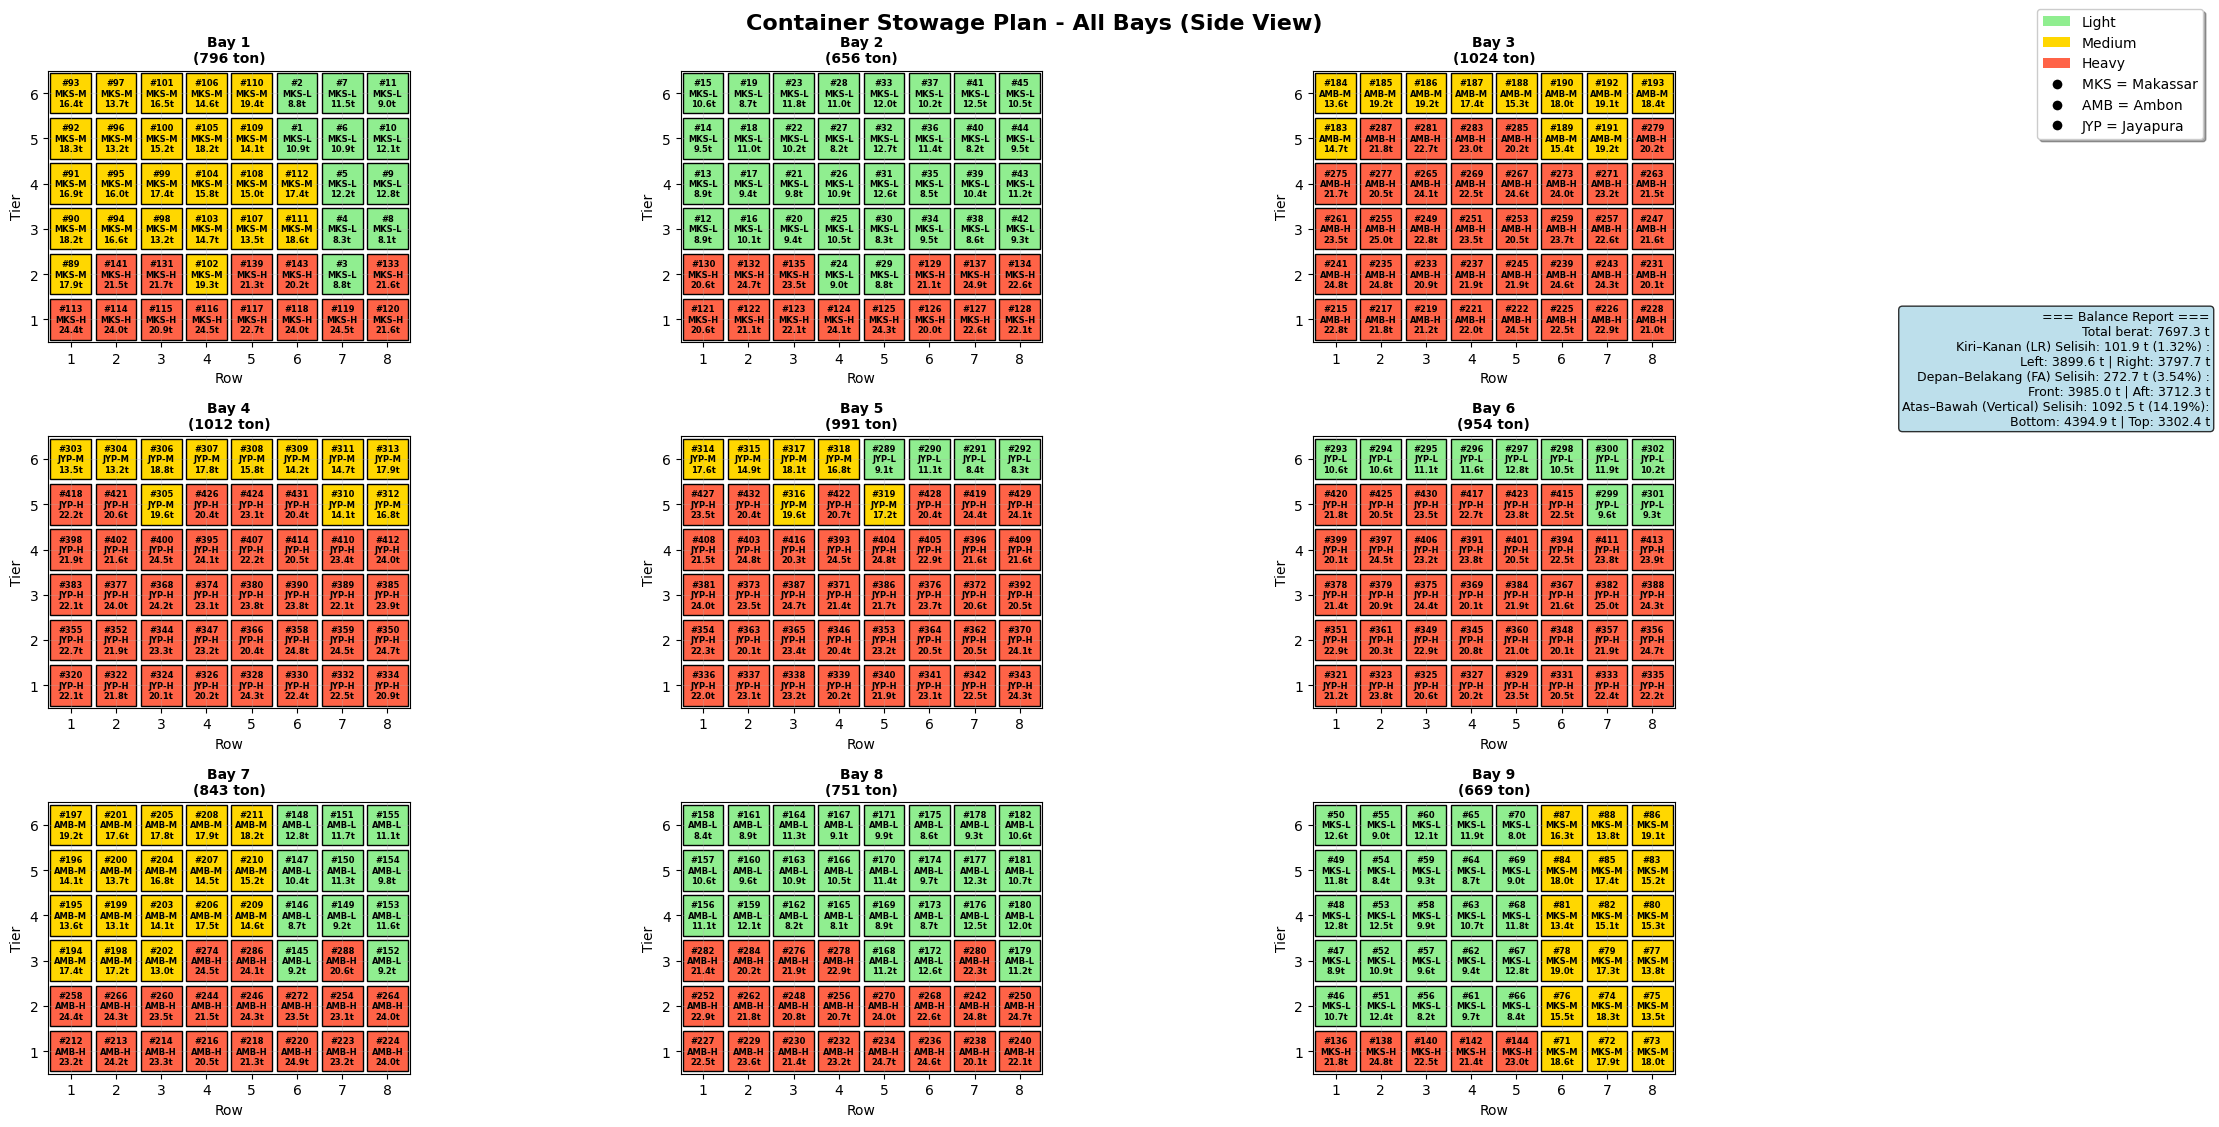

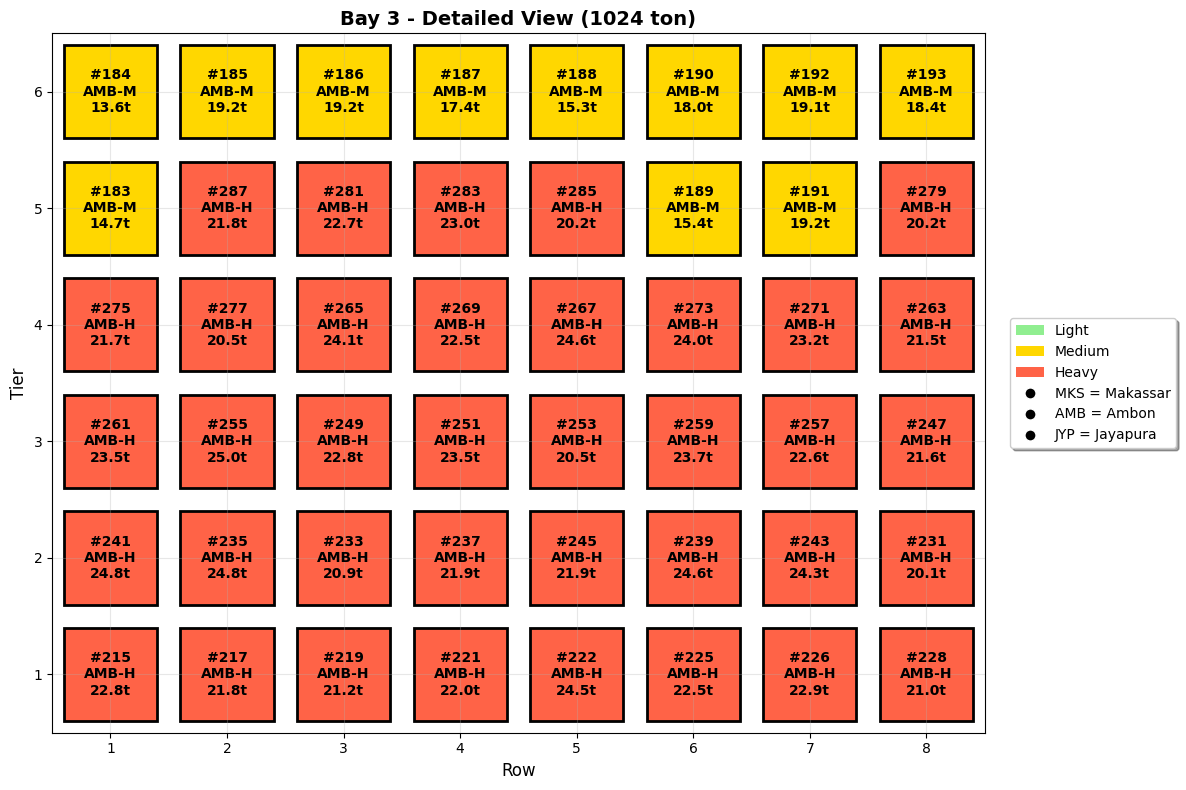

In [33]:
result, analysis = run_simulation()